<a href="https://colab.research.google.com/github/jaysulk/uic_fnal_linac_phase_comp/blob/Energy_Consistant_Loss_Fn/Energy_Consistant_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Please update your drive path to "Phase Compensation" folder
path = "/content/drive/MyDrive/PhaseCompensation/"
ppath = "/content/drive/MyDrive/"
#Please make sure all these files are present in your drive
# 20240208_163623_nominal.csv
# 20241216_084110_nominal_oneTS.csv
# 20241219_104803_nominal_oneTS.csv
#sensor_positions.json

In [ ]:
#Please update the test file path
path_test = "/content/drive/MyDrive/PhaseCompensation/20241223_161613_nominal_oneTS.csv"

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import scipy.fft as spft
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import torch
import torch.fft as fft

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch.nn.functional as F

In [ ]:
def fetch_data(file,datacols,cuts,setdevs):

    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    # 26/02/2024: inverse the logic, keep the read and remove the set
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter|stamp')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    subset.dropna(inplace=True)

    return subset


In [ ]:
def load_BPMphase_data_multi(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            # 26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cav[2:] for cav in cavs])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                   df[col] = df[col].apply(lambda x : x if x > 0 else x +360)


        dfs.append(df)
    #print(dfs)
    return dfs


In [ ]:
### Load BPM location data
json_file = open(f'{ppath}sensor_positions.json')
BPM_positions = json.load(json_file)

devices_to_drop = [ 'L:BPM2OF','L:BPM3IF','L:BPM3OF','L:BPM5IF',"L:BPM4IF","L:BPM5OF","L:D44BF"] #remove DTL part & D44 noisy

for device in devices_to_drop:
    try:
        del BPM_positions[device]
    except:
        continue

BPM_list = list(BPM_positions.keys())
dist_data = list(BPM_positions.values())
print(BPM_list)

cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
# Phase setting - this is the control knob
cavs = ['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET','L:RFQPAH']
# Phase readback - data from physical phase pickups. Discrepances between the two are sign of mis- or under- regulation
cavs_read = ['L:V%iSQ'%n for n in range(1,6)]
# Combined list
cavs_both = cavs + cavs_read
basis_choice =(0,1,2,3,4,5,6)

['L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF', 'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF']


In [ ]:
dates = ["20240208_","20241216_","20241219_"]
times = ["163623_nominal","084110_nominal_oneTS",
         "104803_nominal_oneTS"]
files = ['%s%s%s.csv'%(path,d,t) for (d,t) in zip(dates,times)]
lbls = ['Feb 08 nominal','Dec 16 nominal','Dec 19 nominal']
dfs = load_BPMphase_data_multi(cavs_both,files,devices_to_drop,scan=False)
ip=[df[BPM_list].head(100) for df in dfs]
ipp=[i.dropna() for i in ip]
op = [df[cavs].mean() for df in dfs]
opp=[]
for i in range(len(ipp)):
  for j in range(len(ipp[i])):
    opp.append(op[i])

In [ ]:
def plot_fit_traj(cavs,target_trajectory, basis, response_matrix,targetlbl=None):
    if targetlbl:
        target = str(targetlbl)
    else:
        target='Target trajectory'
    idx = 7
    if len(basis)!=7:
        raise ValueError('The basis length must be 7')
    tensor_b_vecs = [torch.stack([torch.tensor(row.values, dtype=torch.float32) for _, row in response_matrix[i].iterrows()]) for i in range(3)]
    target_tensor = torch.stack([torch.tensor(df.values.squeeze(), dtype=torch.float32) for df in target_trajectory])
    coefs = linear_fit_to_basis(tensor_b_vecs,target_tensor)
    return None

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming a model definition similar to this:
class DeepNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def temporal_smoothness_loss(preds, sequence_indices, strength=1e-2):
    """
    Compute temporal smoothness loss for predictions.
    :param preds: Predictions (torch.Tensor) [N x D]
    :param sequence_indices: Sequence indices indicating the sequence each data point belongs to
    :param strength: Strength of the temporal smoothness loss
    :return: Computed temporal smoothness loss
    """
    seq_ids = sequence_indices.unique()
    total_loss = 0.0
    for seq_id in seq_ids:
        seq_mask = sequence_indices == seq_id
        preds_seq = preds[seq_mask]
        if preds_seq.size(0) > 1:
            deltas = preds_seq[1:] - preds_seq[:-1]
            total_loss += deltas.pow(2).mean()
    return strength * total_loss

def compute_particle_density_loss(dfs):
    """
    Compute the particle density loss based on energy differences.

    This function calculates the loss by determining the absolute differences in energy measurements
    across a list of DataFrames that contain BPM (Beam Position Monitor) data. The specific
    columns considered are related to particle densities.

    Parameters:
    dfs (List[pd.DataFrame]): List of DataFrames containing BPM data.

    Returns:
    torch.Tensor: The computed particle density loss.
    """
    # Columns related to particle densities
    particle_density_cols = ['L:V1SQ', 'L:V2SQ', 'L:V3SQ', 'L:V4SQ', 'L:V5SQ']

    all_energy_diffs = []
    for df in dfs:
        for col in particle_density_cols:
            if col in df.columns:
                # Compute the absolute differences in the column values
                diff = df[col].diff().dropna().abs()
                # Append the tensor of differences from this column to the list
                all_energy_diffs.append(torch.tensor(diff.values, dtype=torch.float32))

    # Concatenate all energy differences into a single tensor
    if all_energy_diffs:
        concatenated_diffs = torch.cat(all_energy_diffs, dim=0)
        particle_density_loss = concatenated_diffs.mean()
        return particle_density_loss
    else:
        return torch.tensor(0.0)

def energy_consistent_loss(preds, labels, bpm_dfs, strength=1e-2):
    """
    Compute the energy-consistent loss using particle density loss from BPM data.

    This function calculates the particle density loss from the BPM data and adjusts
    its impact on the overall loss function using a strength parameter.

    Parameters:
    preds (torch.Tensor): Predictions from the model.
    labels (torch.Tensor): Corresponding true class labels for the predictions.
    bpm_dfs (List[pd.DataFrame]): List of DataFrames containing BPM data.
    strength (float, optional): The weight for the energy consistency term. Defaults to 1e-2.

    Returns:
    torch.Tensor: The calculated total loss.
    """
    # Compute particle density loss
    particle_density_loss = compute_particle_density_loss(bpm_dfs)

    # Scale the particle density loss by the strength parameter
    total_loss = strength * particle_density_loss
    return total_loss

def save_checkpoint(model, optimizer, epoch, loss, path):
    """
    Saves the model and optimizer state to a file.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)

def linear_fit_to_basis(X_tensor_list, Y_tensor, bpm_dfs, sequence_length=20, test_size=0.2, batch_size=64, epochs=1000, lr=5e-4, print_every=100):
    """
    X_tensor_list: list of Tensors to be concatenated along dim=0, then viewed to shape (N, 27)
    Y_tensor: Tensor of shape (N, 7)
    bpm_dfs: List of DataFrames for BPM data used for energy-consistent loss
    """
    # 1) build X, Y
    X = torch.cat(X_tensor_list, dim=0).view(-1, 27)
    Y = Y_tensor.view(Y_tensor.shape[0], -1)

    # 2) make class labels for stratification/classification
    unique_classes, class_labels = torch.unique(Y, dim=0, return_inverse=True)

    # 3) split properly: stratify=class_labels (1-D) not Y (2-D)
    X_train, X_test, Y_train, Y_test, labels_train, labels_test = train_test_split(
        X, Y, class_labels, test_size=test_size, shuffle=True, stratify=class_labels
    )

    # 4) wrap in DataLoaders
    train_ds = TensorDataset(X_train, Y_train, labels_train)
    test_ds  = TensorDataset(X_test, Y_test, labels_test)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # 5) model, optimizer, losses
    model = DeepNN(input_dim=27, output_dim=7)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    regression_loss_fn = nn.MSELoss()
    classification_loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    test_losses  = []

    for epoch in range(epochs):
        # ——— TRAIN ———
        model.train()
        running_train_loss = 0.0
        for x_batch, y_batch, lbl_batch in train_loader:
            optimizer.zero_grad()
            out = model(x_batch)

            # regression term
            loss_reg = regression_loss_fn(out, y_batch)
            # classification term
            dists = torch.cdist(out, unique_classes)
            logits = -dists
            loss_class = classification_loss_fn(logits, lbl_batch)
            # energy and temporal
            loss_energy = energy_consistent_loss(out, lbl_batch, bpm_dfs)
            # Ensure sequence_length is applied correctly to generate seq_ids for the current batch
            # Calculate actual sequence length for the current batch to prevent index out of bounds errors
            current_batch_size = len(lbl_batch)
            batch_sequence_length = min(sequence_length, current_batch_size)
            seq_ids = (torch.arange(current_batch_size) // batch_sequence_length).to(out.device)
            loss_temp = temporal_smoothness_loss(out, seq_ids)


            loss = loss_reg + loss_class + loss_energy + loss_temp
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * x_batch.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # ——— EVAL ———
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch, _ in test_loader:
                out = model(x_batch)
                running_test_loss += regression_loss_fn(out, y_batch).item() * x_batch.size(0)
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        # ——— LOG & CHECKPOINT ———
        if epoch % print_every == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:4d} ▶ train_loss: {epoch_train_loss:.6f}  "
                  f"test_loss: {epoch_test_loss:.6f}")
            save_checkpoint(model, optimizer, epoch, epoch_test_loss,
                            path="checkpoint_epoch-{}.pth")

    # ——— PLOT ———
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, test_losses

def plot_fit_traj(cavs, target_trajectory, basis, response_matrix, targetlbl, files, dropdevs):
    """
    Function to plot the fit trajectory. This will load the BPM data and call the linear_fit_to_basis function.

    :param cavs: List of cavities.
    :param target_trajectory: Target trajectory.
    :param basis: Basis for the fit.
    :param response_matrix: Response matrix.
    :param targetlbl: Target labels.
    :param files: List of files containing the data.
    :param dropdevs: Devices to drop from the data.
    """
    tensor_b_vecs = [torch.stack([torch.tensor(row.values, dtype=torch.float32) for _, row in response_matrix[i].iterrows()]) for i in range(3)]
    target_tensor = torch.stack([torch.tensor(df.values.squeeze(), dtype=torch.float32) for df in target_trajectory])

    # Load BPM data
    bpm_dfs = load_BPMphase_data_multi(cavs, files, dropdevs)

    # Perform linear fit basis
    model, train_losses, test_losses = linear_fit_to_basis(tensor_b_vecs, target_tensor, bpm_dfs)

    return

Epoch    0 ▶ train_loss: 13745.747135  test_loss: 10478.490234
Epoch  100 ▶ train_loss: 10.574711  test_loss: 0.775157
Epoch  200 ▶ train_loss: 11.309729  test_loss: 0.915731
Epoch  300 ▶ train_loss: 11.663639  test_loss: 0.599681
Epoch  400 ▶ train_loss: 10.912492  test_loss: 0.521006
Epoch  500 ▶ train_loss: 10.556554  test_loss: 0.408302
Epoch  600 ▶ train_loss: 11.034112  test_loss: 0.562825
Epoch  700 ▶ train_loss: 11.066004  test_loss: 0.444693
Epoch  800 ▶ train_loss: 11.341786  test_loss: 1.235717
Epoch  900 ▶ train_loss: 11.646248  test_loss: 0.875100
Epoch  999 ▶ train_loss: 10.313494  test_loss: 1.233413


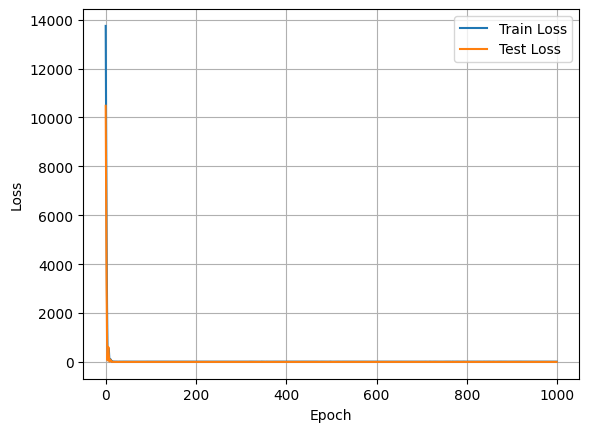

In [ ]:
plot_fit_traj(cavs, opp, basis_choice, ipp, 'a', files, devices_to_drop)

In [ ]:
files = [path_test]
dfs = load_BPMphase_data_multi(cavs_both,files,devices_to_drop,scan=False)
tip=[df[BPM_list].mean() for df in dfs]
top = [df[cavs].mean() for df in dfs]

def predict_single_input(input_1x27, checkpoint_path="checkpoint_epoch-800.pth"):
    # Ensure input is a torch tensor of shape (1, 27)
    if isinstance(input_1x27, list) or isinstance(input_1x27, np.ndarray):
        input_tensor = torch.tensor(input_1x27, dtype=torch.float32).view(1, -1)
    elif isinstance(input_1x27, torch.Tensor):
        input_tensor = input_1x27.view(1, -1)
    else:
        raise ValueError("Input must be a list, numpy array, or torch tensor.")

    model = DeepNN(input_dim=27, output_dim=7)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        return output.numpy()


test_input = tip[0].values
test_tensor = torch.tensor(test_input, dtype=torch.float32)
predicted_output = predict_single_input(test_tensor)

print("Predicted Output:", predicted_output[0])
print("Actual output:",top[0])

Predicted Output: [235.1805   -34.22428  -26.458126 -39.9523   -22.933626 -36.35771
 227.57213 ]
Actual output: L:RFBPAH    233.560181
L:V1QSET    -34.119999
L:V2QSET    -26.400000
L:V3QSET    -40.099998
L:V4QSET    -23.000000
L:V5QSET    -36.199989
L:RFQPAH    229.608154
dtype: float64
